<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Константная-модель" data-toc-modified-id="Константная-модель-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Константная модель</a></span></li><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Подведем-итоги" data-toc-modified-id="Подведем-итоги-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Подведем итоги</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Критерий: Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

## Подготовка

In [170]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import rcParams, rcParamsDefault
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

# инструменты
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [171]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [172]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Пропусков в данных нет, предобработка не требуется

In [173]:
data.sort_index(inplace=True)

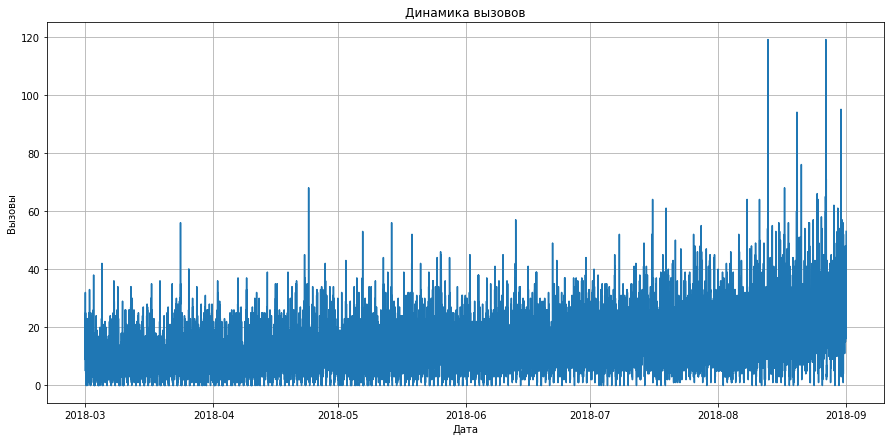

In [174]:
plt.figure(figsize=(15, 7))
plt.xlabel('Дата')
plt.ylabel('Вызовы')
plt.title('Динамика вызовов')
plt.grid(True)
plt.plot(data)
plt.show()

Некоторые дни имеют пиковую активность, ближе к сентябрю спрос на такси вырос.

Выполним ресемплировнаие данных с разделеинем по одному часу.

In [175]:
data = data.resample('1H').sum()

In [176]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Напишем функцию для создания новых признаков

In [177]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data
    data_new['year'] = data_new.index.year
    data_new['month'] = data_new.index.month
    data_new['day'] = data_new.index.day
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

## Анализ

Проанализируем динамику вызовов на промежутке март-сентябрь 2018

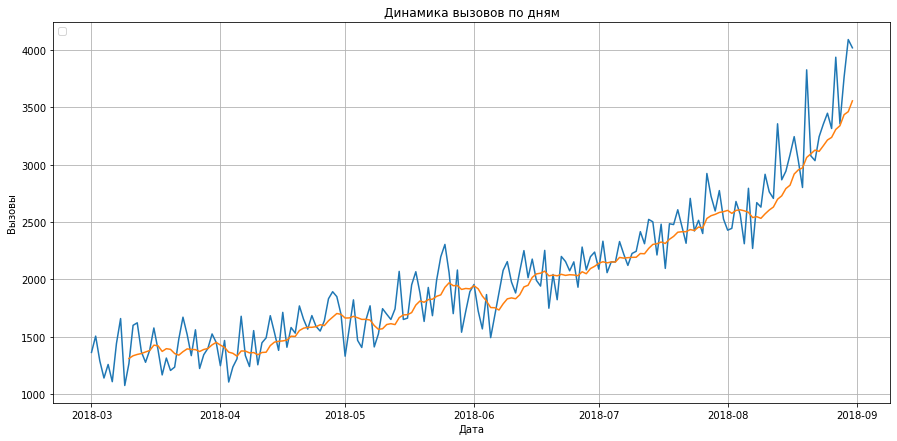

In [178]:
plt.figure(figsize=(15, 7))
plt.xlabel('Дата')
plt.ylabel('Вызовы')
plt.title('Динамика вызовов по дням')
plt.legend(['sdf', 'sdgs'], loc=2)
plt.plot(data.resample('1D').sum())
plt.plot(data.resample('1D').sum().rolling(10).mean())
plt.grid(True)
plt.show()

Начиная с января, среднее количество вызовов возрастает к концу каждого месяца, при этом общая тенденция показывает рост количества ежедневных вызовов к сентябрь, что может быть связано с началом учебного года.

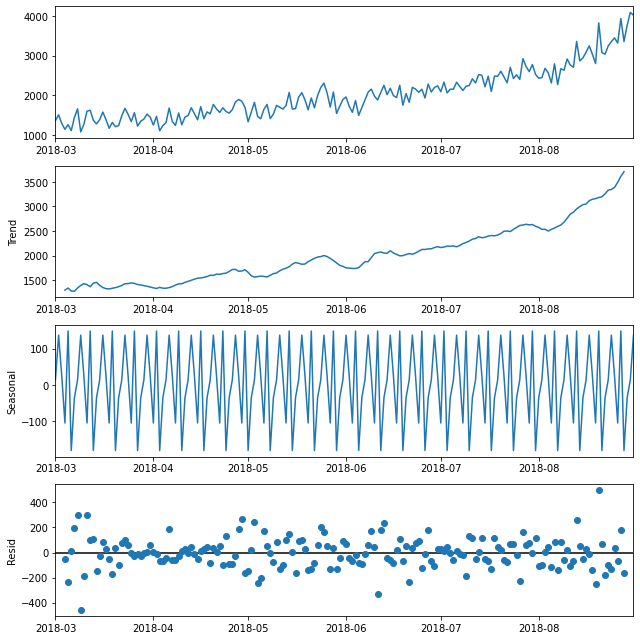

In [179]:
rcParams['figure.figsize'] = 9, 9
decompose = seasonal_decompose(data.resample('1D').sum())
decompose.plot()
plt.show()

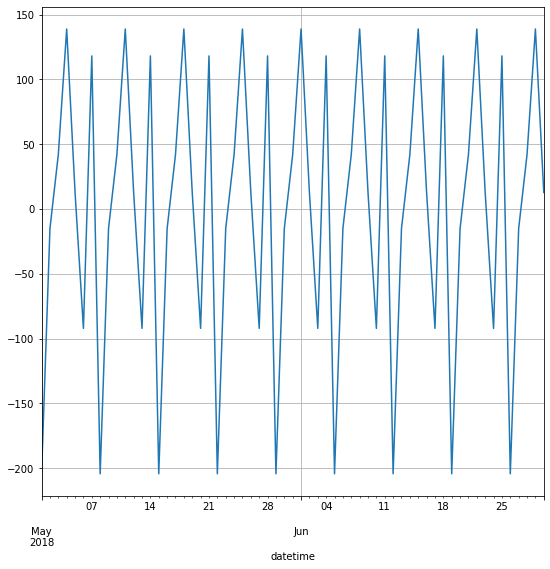

In [180]:
rcParams['figure.figsize'] = 9, 9
decompose = seasonal_decompose(data['2018-05':'2018-06'].resample('1d').sum()).seasonal
decompose.plot()
plt.grid(True)
plt.show()

График тренда имеет восходящий характер, что говорит о росте спроса ближе к концу года. При этом данные обладают качеством сезонности в одну неделю с пиковыми нагрузками в середине недели и на выходных.

## Обучение

### Линейная регрессия

Создадим функцию расчета RMSE

In [181]:
def rmse (target, predict):
    return mean_squared_error(target, predict)**0.5

In [182]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

Изучим влияние количества признаков с отстающими значениями и коэффициента скользящего среднего.

In [183]:
# %%time
# result_train = []
# for i in range(100, 1001, 50):
#     result_1 = []
#     for j in range(10, 101, 10):
#         data_exp = make_features(data, i, j)
#         train, test = train_test_split(data_exp, shuffle=False, test_size=0.1)
#         train = train.dropna()

#         y_train, y_test = train['num_orders'], test['num_orders']
#         X_train, X_test = train.drop(columns=['num_orders']), test.drop(columns=['num_orders'])
        
#         model = LinearRegression()
#         model.fit(X_train, y_train)
        
#         predict_1 = model.predict(X_train)
#         score_1 = rmse(predict_1, y_train)
#         result_1.append(score_1)
        
#     result_train.append(result_1)

In [184]:
# result = pd.DataFrame(result_train, range(100, 1001, 50), range(10, 101, 10))

In [185]:
# result

In [186]:
# result.min()

In [187]:
# пустая строка

Для кросс-валидации временного ряда используем TimeSeriesSplit

In [208]:
cv = TimeSeriesSplit()

Определим примерную величину сдвига временного ряда для формирования признаков исходя из размера тестовой выборки.

In [190]:
sh = data.shape[0] * 0.1
sh = int(sh)
sh

441

In [191]:
data_feat = make_features(data, sh, 10)

Разделим выборку на тренировочную и тестовую

In [192]:
train, test = train_test_split(data_feat, shuffle=False, test_size=0.1)
train = train.dropna()

y_train, y_test = train['num_orders'], test['num_orders']
X_train, X_test = train.drop(columns=['num_orders']), test.drop(columns=['num_orders'])

In [193]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Columns: 446 entries, year to rolling_mean
dtypes: float64(442), int64(4)
memory usage: 1.5 MB


In [194]:
model = LinearRegression()
model.fit(X_train, y_train)    

LinearRegression()

In [195]:
model_pred = model.predict(X_train)
rmse(model_pred, y_train)

19.24444432471411

In [196]:
line_cv = -cross_val_score(model, X_train, y_train, cv=cv, scoring=rmse_scorer).mean()

In [197]:
line_cv

26.885114117929547

RMSE тренировочной выборки 26.88 далее рассмотрим другие модели.

### Константная модель

In [201]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train, y_train)

DummyRegressor(strategy='median')

In [202]:
dummy_pred = dummy_regr.predict(X_train)
rmse(dummy_pred, y_train)

38.93054844982304

In [203]:
-cross_val_score(dummy_regr, X_train, y_train, cv=cv, scoring=rmse_scorer).mean()

40.433800377981456

Константная модель устанавливает порог в 40.43 RMSE

### GradientBoostingRegressor

In [204]:
gbr = GradientBoostingRegressor(random_state=12345)

In [144]:
gbr_params = {}
gbr_params['n_estimators'] = [i for i in np.arange(300, 350, 10)]
gbr_params['max_depth'] = [i for i in np.arange(4, 8)]
gbr_params['min_samples_split'] = [i for i in np.arange(6, 12, 2)]

In [209]:
gbr_random = RandomizedSearchCV(gbr, gbr_params, n_iter=5, cv=cv, verbose=2,
                                  random_state=12345, scoring=rmse_scorer, n_jobs=-1)

In [210]:
%%time
gbr_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END .max_depth=7, min_samples_split=8, n_estimators=300; total time=  32.4s
[CV] END .max_depth=7, min_samples_split=8, n_estimators=300; total time= 1.0min
[CV] END .max_depth=7, min_samples_split=8, n_estimators=300; total time= 1.5min
[CV] END .max_depth=7, min_samples_split=8, n_estimators=300; total time= 2.0min
[CV] END .max_depth=7, min_samples_split=8, n_estimators=300; total time= 2.6min
[CV] END max_depth=6, min_samples_split=10, n_estimators=320; total time=  29.8s
[CV] END max_depth=6, min_samples_split=10, n_estimators=320; total time=  57.1s
[CV] END max_depth=6, min_samples_split=10, n_estimators=320; total time= 1.4min
[CV] END max_depth=6, min_samples_split=10, n_estimators=320; total time= 1.9min
[CV] END max_depth=6, min_samples_split=10, n_estimators=320; total time= 2.3min
[CV] END .max_depth=6, min_samples_split=6, n_estimators=300; total time=  27.9s
[CV] END .max_depth=6, min_samples_split=6, n_est

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=GradientBoostingRegressor(random_state=12345),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'max_depth': [4, 5, 6, 7],
                                        'min_samples_split': [6, 8, 10],
                                        'n_estimators': [300, 310, 320, 330,
                                                         340]},
                   random_state=12345,
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=2)

In [211]:
gbr_random.best_params_

{'n_estimators': 320, 'min_samples_split': 8, 'max_depth': 5}

In [212]:
abs(gbr_random.best_score_)

23.4612700624237

Градиентный бустинг по результатам кросс-валидации показал 23 RMSE

### Случайный лес

In [150]:
forest = RandomForestRegressor(random_state=12345)

In [151]:
distributions = {}
distributions['n_estimators'] = [i for i in np.arange(400, 500, 10)]
distributions['max_depth'] = [None] + [i for i in range(1, 3)]
distributions['bootstrap'] = [True, False]

In [153]:
forest_random = RandomizedSearchCV(forest, distributions, n_iter=7, cv=cv, verbose=2,
                                  random_state=12345, scoring=rmse_scorer, n_jobs=-1)

In [154]:
%%time
forest_random.fit(X_train, y_train)

Fitting 9 folds for each of 7 candidates, totalling 63 fits
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   0.7s
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   1.0s
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   1.4s
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   1.7s
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   2.1s
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   2.5s
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   2.9s
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   3.2s
[CV] END .....bootstrap=False, max_depth=2, n_estimators=400; total time=   3.6s
[CV] END .....bootstrap=False, max_depth=1, n_estimators=420; total time=   0.5s
[CV] END .....bootstrap=False, max_depth=1, n_estimators=420; total time=   0.7s
[CV] END .....bootstrap=False, max_depth=1, n_est

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   n_iter=7, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 1, 2],
                                        'n_estimators': [400, 410, 420, 430,
                                                         440, 450, 460, 470,
                                                         480, 490]},
                   random_state=12345,
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=2)

In [67]:
forest_random.best_params_

{'n_estimators': 480, 'max_depth': 3, 'bootstrap': True}

Для ускорения процесса создам отдельную модельна основании подобранных параметров.

In [216]:
forest = RandomForestRegressor(random_state=12345, n_estimators=480, max_depth=3, bootstrap=True)

In [217]:
forest_cv = -cross_val_score(forest, X_train, y_train, cv=cv, scoring=rmse_scorer).mean()

In [218]:
forest_cv

24.627639928785072

Модель случайного леса показала 33.10 RMSE

### Подведем итоги

In [219]:
pd.DataFrame([[line_cv, abs(gbr_random.best_score_), forest_cv]], columns=['Linear', 'Gradient', 'RForest'], index=['model'])

,Linear,Gradient,RForest
model,26.885114,23.46127,24.62764


Наилучший результат при обучении модели на тестовых данных показал градиентный бустинг 23.46, проверим модель на тестовой выборке.

## Тестирование

In [220]:
gbr_random.best_estimator_

GradientBoostingRegressor(max_depth=5, min_samples_split=8, n_estimators=320,
                          random_state=12345)

In [221]:
predict_test = gbr_random.best_estimator_.predict(X_test)
print("RMSE тестовой выборки:", rmse(predict_test, y_test))

RMSE тестовой выборки: 37.20156486752845


Значение метрики RMSE на тестовой выборке 37.20, что соответствует условиям задачи не больше 48. Модель годится для предсказания.